# Image Segmentation
Identifying where the person is in the source image.
Uses scikit-image


### Some familiarisation with the code
    Importing a GrayScale Image from the skimage library

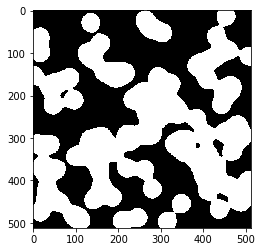

In [6]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt

image = data.binary_blobs()
plt.imshow(image,cmap='gray');

    Importing a Coloured Image from the skimage library

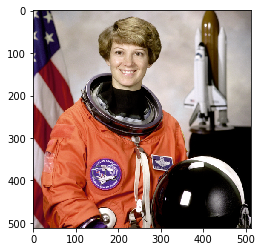

In [7]:
image = data.astronaut()
plt.imshow(image);

    Importing an image from an external source

In [8]:
from skimage import io # Basically the io library helps import the image into your python workspace
image = io.imread('skimage_logo.png')
plt.imshow(image);

FileNotFoundError: [Errno 2] No such file or directory: 'skimage_logo.png'

    Loading multiple images

In [9]:
images = io.ImageCollection('../images/*.png:../images/*.jpg')
print('Type:',type(images))
images.files

Type: <class 'skimage.io.collection.ImageCollection'>


[]

    Saving images

In [10]:
io.imsave('logo.png',logo)

NameError: name 'logo' is not defined

##### Image segmentation is the process of partitioning a digital image into multiple segments to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.

Supervised segmentation: Some prior knowledge, possibly from human input, is used to guide the algorithm. Examples include Thresholding, Active Contour ("Snakes"), Random Walker.

Unsupervised segmentation: No prior knowledge is required. These algorithms attempt to subdivide images into meaningful regions automatically. The user may still be able to tweak certain settings to obtain desired outputs. Examples include Thresholding with filters, Simple Linear Iterative Clustering, Felzenszwalb.

### Thresholding
Simplest way to segment objects from a background by choosing pixels above or below a certain threshold.

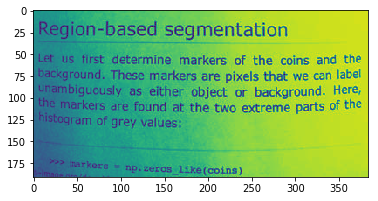

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

text = data.page()
plt.imshow(text);

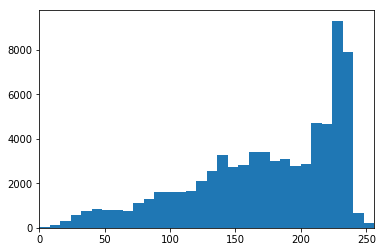

In [12]:
fig,ax = plt.subplots(1,1)
ax.hist(text.ravel(),bins=32,range=[0,256])
ax.set_xlim(0,256);

The above histogram shows the number of pixels in an image at different intesity values found in that image. So there are more than 8000 pixels with intensity 225 bits (remember, the image is an 8-bit image, which means each intensity goes from 0 to 256. 0: black, 255: white

An ideal segmentation histogram would be bimodal and fairly separated so that we could pick a number right in the middle. Now let's just try and make a few segmented images based on simple thresholding.

### Supervised Thresholding
Because we choose the threshold values ourselves.

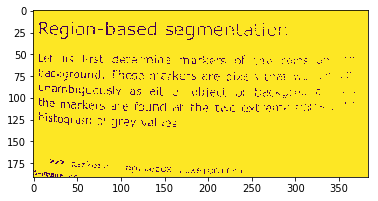

In [13]:
text_segmented = text > 50 # Intensities greater than 70 bits Try 50, 70, 120
plt.imshow(text_segmented);

Not really a good result because you want to words to come off its coloured background.

### Let's try using unsupervised thresholding
Scikit-image has a number of automatic thresholding methods, which require no input in choosing an optimal threshold. Some of the methods are : otsu, li, local.

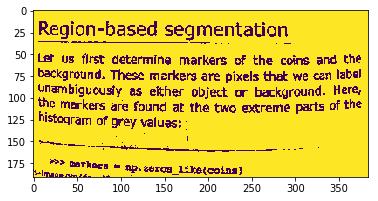

In [14]:
text_threshold = filters.threshold_local(text,block_size=51,offset=10)
plt.imshow(text > text_threshold);

Words are contrasted against their background - good.

### Another segmentation
For this section, we will use an example image which is freely available and attempt to segment the head portion using supervised segmentation techniques.

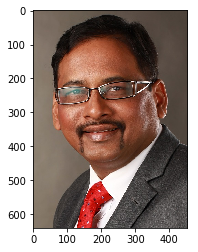

In [15]:
# import the image
from skimage import io
image = io.imread('girl.jpg')
plt.imshow(image);

Before doing any segmentation on an image, it is a good idea to de-noise it using some filters. Here, since the image is not very noisy, we will take it as it is.

We convert the image to grayscale.

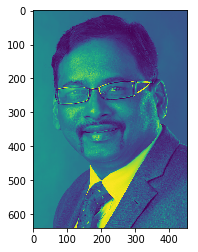

In [16]:
image_gray = color.rgb2gray(image)
plt.imshow(image_gray);

### Active Contour Segmentation ("Snakes")
Initialised using a user-defined contour or line, around the area of interest and this contour then slowly contracts and is attracted or repelled from light and edges. WOW

For our image, let's draw a circle around the person's head to initialise the snake.

In [17]:
def circle_points(resolution,center,radius):
    """
        Generate points which define a circle on an image.
        Center refers to the center of the circle.
        """
    radians = np.linspace(0,2*np.pi,resolution)
    c = center[0] + radius*np.cos(radians)
    r = center[1] + radius*np.sin(radians)
    return np.array([c,r]).T

points = circle_points(200,[220,250],240)[:-1] # Exclude last point because a closed path should not have duplicate points


The above calculations calculate x and y co-ordinates of the points on the periphery of the circle. Since we have given the resolution to be 200, it will calculate 200 such points.

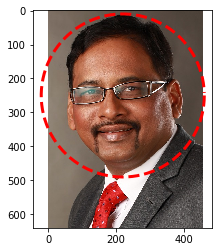

In [18]:
plt.imshow(image)
plt.plot(points[:,0],points[:,1],'--r',lw=3)

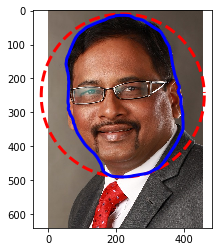

In [19]:
# Higher values of alpha will make the snake contract faster while beta makes the snake smoother
snake = seg.active_contour(image, points,alpha = 0.06, beta = 0.3) 

plt.imshow(image)
plt.plot(points[:, 0], points[:, 1], '--r', lw=3)
plt.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

### Random Walker Segmentation
A user interactively labels a small number of pixels which are known as labels. Each unlabelled pixel is then imagined to release a random walker and one can then determine the probability of a random walker starting at each unlabelled pixel and reaching one of the prelabelled pixels. By assigning each pixel to the label for which the greatest probability is calculated, high-quality image segmentation may be obtained.

THIS IS COOL.

In [20]:
image_labels = np.zeros(image.shape,dtype=np.uint8)

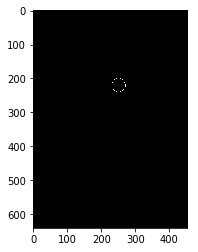

In [21]:
indices = draw.circle_perimeter(220,250,20)
image_labels[indices] = 255
#image_labels[points[:,1].astype(np.int),points[:,0].astype(np.int)] = 2
plt.imshow(image_labels);

In [ ]:
image_segmented = seg.random_walker(image, image_labels, beta = 3000)
# Check our results
fig = plt.imshow(image_gray)
plt.imshow(image_segmented == 1, alpha=0.3);

### Unsupervised Segmentation
The idea is that you have an image that is so large that it is not feasible to consider all pixels simultaneously. So unsupervised segmentation breaks down the image into several sub-regions, so instead of millions of pixels you only have tens to hundreds of regions.

Simple Linear Iterative Clustering (SLIC)
Actually uses a machine learning technique called k-means. It takes in all the pixel values of the image and tries to separate them out into the given number of sub-regions.

Works in colour. *IMPORTANT!!!*

In [25]:
image_slic = seg.slic(image,n_segments=155)

All we’re doing is just setting each sub-image or sub-region that we have found, to the average of that region which makes it look less like a patchwork of randomly assigned colors and more like an image that has been decomposed into areas that are kind of similar.

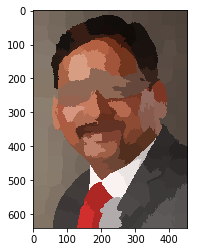

In [26]:
# label2rgb replaces each discrete label with the average interior colour
plt.imshow(color.label2rgb(image_slic,image,kind='avg'))

We have reduced this image down to 155 regions.

### Felzenszwalb
Uses a machine learning algorithm called minimum-spanning tree clustering. Felzenszwalb doesn't tell us the exact number of clusters that the image will be partitioned into. It's going to run and generate as many clusters as it thinks is appropriate for that given scale or zoom factor on the image.

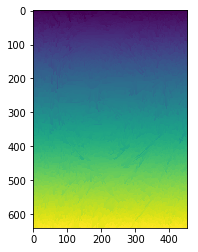

In [28]:
image_felzenszwalb = seg.felzenszwalb(image)
plt.imshow(image_felzenszwalb)

Don't worry, we will recolour this mess.

In [29]:
np.unique(image_felzenszwalb).size

4387

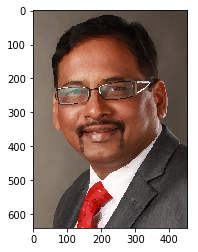

In [30]:
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, image, kind='avg')
plt.imshow(image_felzenszwalb_colored);

What you get is essentially a posterised image - just a reduction in the number of colours.

### Conclusion
Image segmentation is a very important image processing step. It is an active area of research with applications ranging from computer vision to medical imagery to traffic and video surveillance. Python provides a robust library in the form of scikit-image having a large number of algorithms for image processing.